# Description

This notebook looks at some simple statistics of histortical intraday equity data. First we look at midprice and microprice, then order imbalance, stamped every 100 millisecond of the trading day. We will see that order imbalance tends to mean-revert, and has siginificant auto-correlation. Next, we look at the behaviour of order imbalance an instant before market order buys or sells arrive. The interesting aspect of this is that buy orders tend to arrive when the order imbalance is tilted to the buy side, while sell orders tend to arrive when the order imbalance is tilted to the sell side.

In [17]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.rcParams.update(params)

## load data

In [2]:
data = sio.loadmat(r"HFT_22-main\HFT_22-main\CW Data\AMZN_20141104.mat")

In [3]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

## Midprice, Microprice and Spread

In [4]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

plot midprice

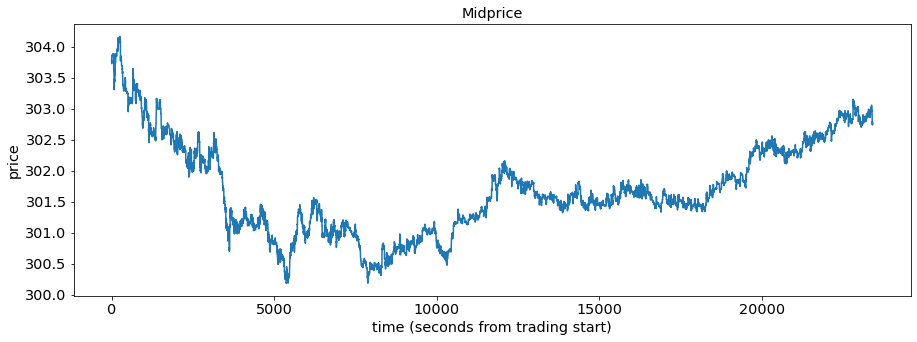

In [18]:
plt.plot(t, midprice)
plt.title('Midprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

plot microprice

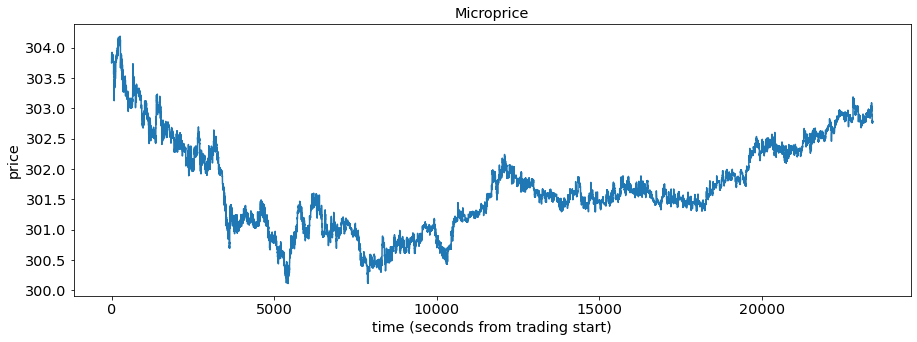

In [19]:
plt.plot(t, microprice)
plt.title('Microprice')
#plt.rcParams
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

#### Volatility of the stock

In [48]:
import pandas as pd
df = pd.DataFrame(midprice, columns=['midprice'])

In [51]:
vol = df.midprice.pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(23400)
print('volatility: ', round(vol*100,3),'%')

volatility:  0.348 %


plot the difference between micro and mid prices

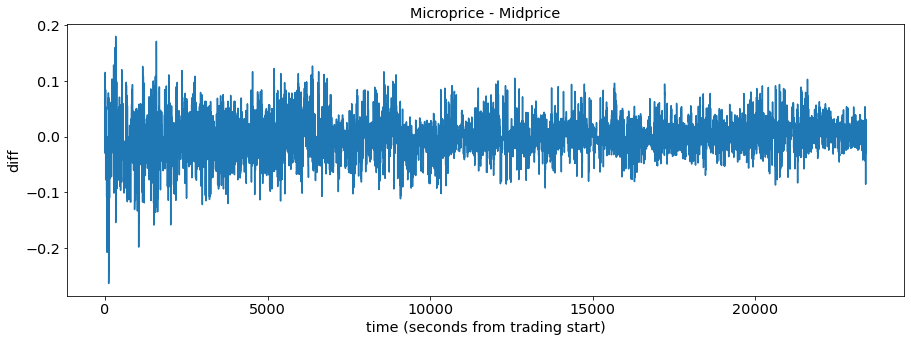

In [20]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

Note that the difference is typically in the range [-0.1, 0.1] while at the beginning of the day it is two times as large.

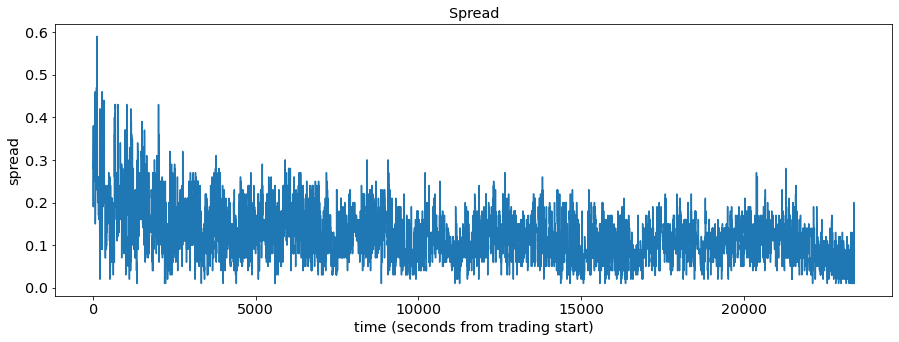

In [21]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.show()

This plot shows that the spread is about 0.6 in the morning, but quickly drops to a value between 0 and 0.2 

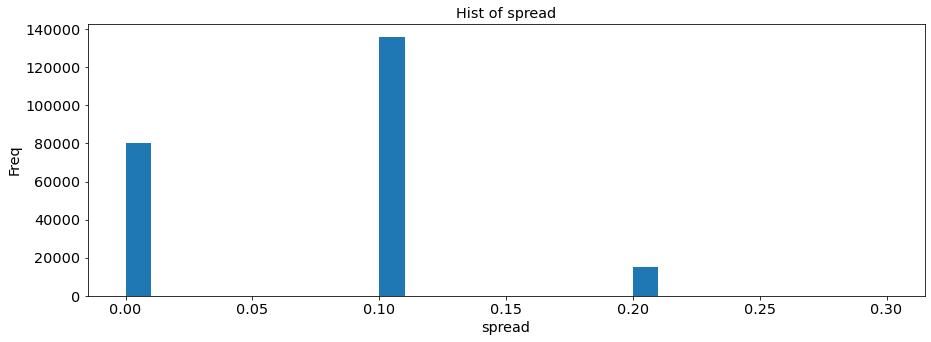

In [22]:
plt.hist(spread,bins=[0, 0.1,0.2,0.3], width=0.01,align='mid') 
plt.title("Hist of spread")
plt.xlabel(r'spread')
plt.ylabel('Freq')
plt.show()

In [28]:
len(spread)

234000

## Volume Imbalance

In [30]:
net_order_flow = (sum(bidvol[:,0]) - sum(askvol[:,0]))
print(net_order_flow)

487850.0


In [37]:
# MO=np.array(LOB['MO'][0][0]*1.0)
# MO.shape
# print(sum(MO[:,3]-MO[:,4]))
print(sum(MO[:,3])- sum(MO[:,4]))
print(sum(MO[:,3]), sum(MO[:,4]))

99569.0
987706.0 888137.0


In [10]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

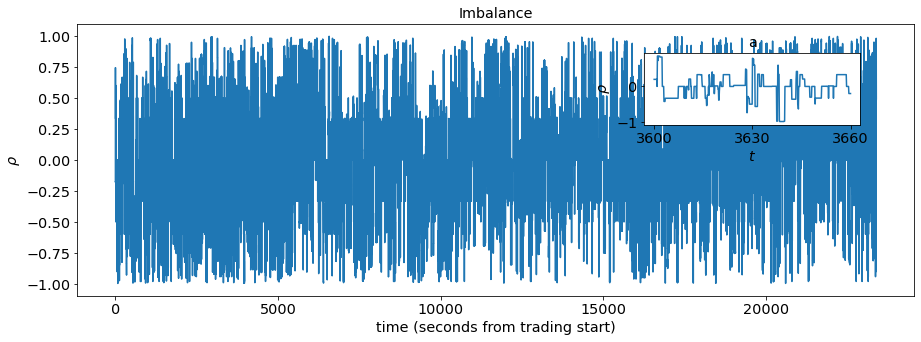

In [23]:
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

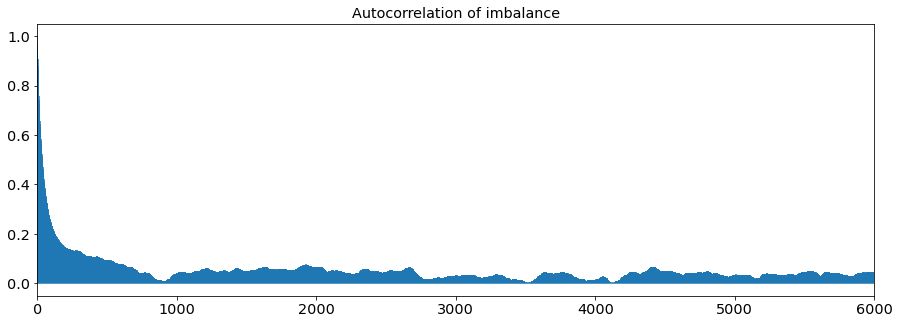

In [24]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,6000])
plt.show()

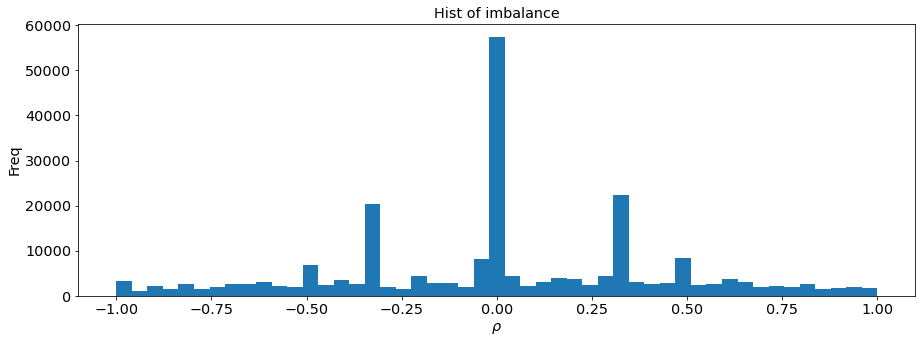

In [25]:
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

## Volume Imbalance at times of Market Orders

In [14]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

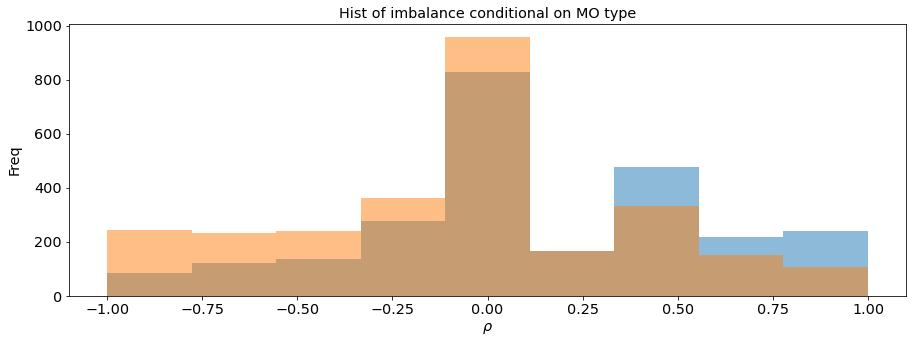

In [26]:
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of imbalance conditional on MO type")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

## Liquidation with Permanent Price Impact

### Introduction

This notebook explores  optimal execution strategies in the simpliest setting. The theory is covered in Chap 6.5 of

Algorithmic and High-Frequency Trading (c) Cartea, Jaimungal, & Penalva, 2015 Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

The agent controls their speed of trading $\nu$, and assumes that she receives an execution price of
$$
S_t^{\nu} - k\, Q_t^{\nu}
$$
which is linear in her trading rate to account for the cost of walking the limit order book. Furthermore, her trading induces a drift in the asset price, which is otherwise assmed to be a Brownian motion. Hence, $S^{\nu}_t$ satisfies the SDE
$$
dS_t^\nu = a \,\nu_t\,dt + \sigma \, dW_t
$$
She aims to maximize the  performance criterion 
$$
\mathbb{E}\Big[ X_T^{\nu} + Q_T^{\nu}(S_T^{\nu} - \alpha Q_T^{\nu}) - \phi \int_0^T (Q_u^{\nu})^2\, du\Big]
$$
where $X_T^\nu$ is the total cash from trading, and the term $\alpha\,(Q_T^\nu)^2$ represents a penalty on holding terminal inventory (which we will send to infinity to guarantee liquidation).

### Solving DPE

As shown in the chapter, the dynamic programming principle implies that the value function satisfies the $\textbf{HJB}$ equation
\begin{equation}
0 = (\partial_t + \tfrac{1}{2}\sigma^2\partial_{SS})H - \phi q^2 + \sup_{\nu}\{(\nu(S - f(\nu))\partial_x - g(\nu) \partial_S - \nu \partial_q)H\}
\end{equation}

subject to the terminal condition $H(T,x,S,q) = x + Sq - \alpha q^2$.

For the case of linear impact functions $f(\nu)=k\,\nu$ and $g(\nu)=b\,\nu$, the  $\textbf{DPE}$ can be solved explicitly and the optimal speed to trade is
\begin{equation}
\nu_t^* = \gamma \frac{\zeta e^{\gamma(T-t)} + e^{-\gamma(T-t)}}{\zeta e^{\gamma(T-t)} - e^{-\gamma(T-t)}}\, Q_t^{{\nu}^*}
\end{equation}

From this equation, it is also possible to obtain the agent's inventory $Q_t^{\nu^*}$ that results from following this strategy.

\begin{equation}
Q_t^{\nu^*} = \frac{\zeta e^{\gamma(T-t)} + e^{-\gamma(T-t)}}{\zeta e^{\gamma(T-t)} - e^{-\gamma(T-t)}} \,Q_0.
\end{equation}

The details of the derivations can be found from Page 145 to Page 147.

Now we show the implementation of the optimal speed to trade at and inventory along the optimal strategy in the following code.

In [ ]:
# Import necessary libraries.
import numpy as np
import import_ipynb
import Liquidation_Permanent_Price_Impact_helper as lppi_helpers

C:\Users\PC\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PC\Python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\PC\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


importing Jupyter notebook from Liquidation_Permanent_Price_Impact_helper.ipynb


The following code computes the optimal speed to trade at $\nu_t^*$ and inventory along the optimal strategy $Q_t^{\nu^*}$.

In [ ]:
# Parameter settings
T = 1
Ndt = 6.5 * 3600
dt = T / Ndt
t = np.arange(0, T + dt, dt)

k = 0.002
b = 0.002
R = 10000

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

myphi = np.array([10e-10, 0.001, 0.01, 0.1])
symb = np.array(["o", "*", "+", "^"])

alpha = 100

Now we use show the change of the investor's inventory along the optimal path for various levels of the running penalty $\phi$ as $\alpha$ changes.

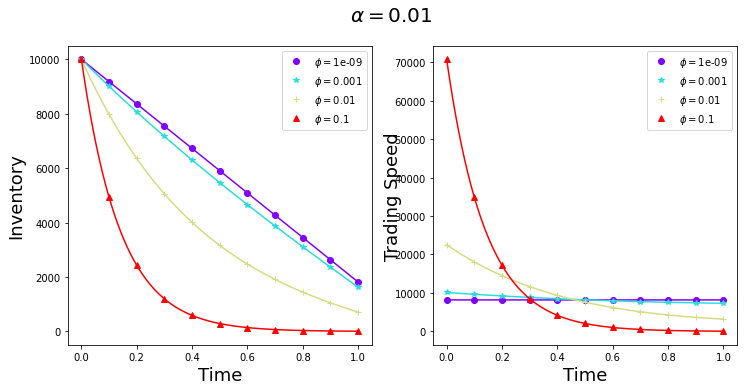

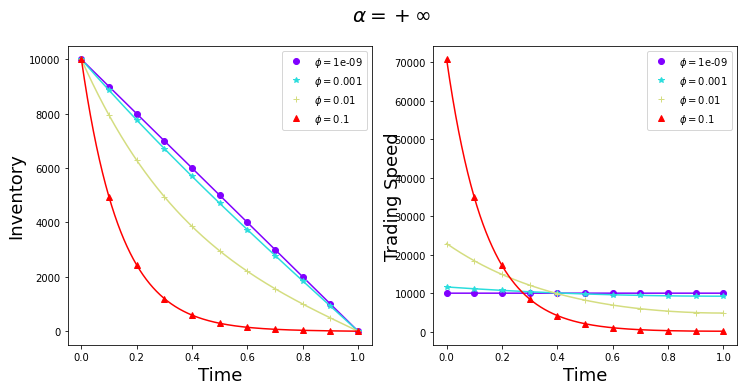

In [ ]:
# Fig 6.2 of Page 148
lppi_helpers.plot_inventory_trading_speed(0.01, myphi, symb, t, tt, T, b, k, R, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.01$")
lppi_helpers.plot_inventory_trading_speed(100, myphi, symb, t, tt, T, b, k,R,  [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = +\infty$")